Latest version

# Capstone 2 : Exploratory Data Analysis

## Recall, at the end of the Data Wrangling notebook we left off with 
    datapath = '../data/processed'
    save_file(data15clean, 'clean15.csv', datapath)
    
## as our cleaned data.

The feature we will be focusing on will be the type of pitch thrown. For now I decided to focus on starting pitchers as they provide more data and are typically required to have a more diverse pitch repoitoire than relief pitchers who only pitch for an inning or 2. 

The data will be acquired from https://www.kaggle.com/pschale/mlb-pitch-data-20152018?select=pitches.csv
which was scraped from  http://gd2.mlb.com/components/game/mlb/.


*I could still consider going back to creating a model for a single player but make the pipeline or function such that the player can be changed easily before running. **

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

In [2]:
import statsmodels.api as sm # This imports statsmodels (uses R style formulas with pd support. 
#https://www.statsmodels.org/stable/index.html)
from statsmodels.graphics.api import abline_plot # Plots a line given slope & intercept
#https://www.statsmodels.org/devel/generated/statsmodels.graphics.regressionplots.abline_plot.html
from sklearn.metrics import mean_squared_error, r2_score # Calculates mse & r^2 score.
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html
from sklearn.model_selection import train_test_split # splits the data into train & test sets.
#uses X-train, X-test, y-train, y-test return format
from sklearn import linear_model, preprocessing # creates & performs OLS regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
#preprocessing is used for scaling
#https://scikit-learn.org/stable/modules/preprocessing.html
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
#from sklearn.linear_model import
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [4]:
#missing values function
def missing(df):
    '''Takes dataframe as argument, 
    returns count and % of missing values for each column'''
    import pandas as pd
    miss = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
    miss.columns = ['count','%']
    return miss.sort_values(by = ['count'], ascending = False)

In [5]:
filepath = '../data/processed/clean15.csv'

In [23]:
data = pd.read_csv(filepath)

We'll use a few standard pandas dataframe methods to review the properties of our cleaned data

In [24]:
data.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


pd get_dummies() 1 hot encoding to create multiple columns from 1 (categorical)

2nd type is label encoding for ordinal features 
get the number of categories, assign value, put into dict, create a map

In [25]:
#double check that we dont have any missing values
missing(data)

,count,%
ab_id,0,0.0
batter_id,0,0.0
on_2b,0,0.0
on_1b,0,0.0
pitch_num,0,0.0
outs,0,0.0
s_count,0,0.0
b_count,0,0.0
b_score,0,0.0
pitch_type,0,0.0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21602 entries, 0 to 21601
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       21602 non-null  int64  
 1   batter_id   21602 non-null  int64  
 2   event       21602 non-null  object 
 3   g_id        21602 non-null  int64  
 4   inning      21602 non-null  int64  
 5   o           21602 non-null  int64  
 6   p_score     21602 non-null  int64  
 7   p_throws    21602 non-null  object 
 8   pitcher_id  21602 non-null  int64  
 9   stand       21602 non-null  object 
 10  top         21602 non-null  bool   
 11  id          21602 non-null  int64  
 12  last_name   21602 non-null  object 
 13  date        21602 non-null  object 
 14  type        21602 non-null  object 
 15  pitch_type  21602 non-null  object 
 16  b_score     21602 non-null  float64
 17  b_count     21602 non-null  float64
 18  s_count     21602 non-null  float64
 19  outs        21602 non-nul

#data.describe()
Encoded:
Nominal or ordinal (ordered) feature (identify)
2 options, label encoding for ordinal 
1 

In [27]:
data.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.066781,0.999990,0.031528,0.025075,-0.038446,-0.080594,-0.029842,-0.080594,-0.011220,-0.004679,0.017584,0.016263,0.013609,-0.023364,0.004234,-0.001584
batter_id,0.066781,1.000000,0.066853,0.015528,-0.015304,0.030050,-0.032001,0.013836,-0.032001,-0.011592,0.013114,0.011350,-0.016523,0.011228,-0.017507,-0.011000,-0.001280
g_id,0.999990,0.066853,1.000000,0.031366,0.025007,-0.039017,-0.080589,-0.030112,-0.080589,-0.011665,-0.004671,0.017591,0.016162,0.013605,-0.023310,0.004133,-0.001563
inning,0.031528,0.015528,0.031366,1.000000,-0.024359,0.463773,-0.038845,-0.026315,-0.038845,0.247558,0.002325,-0.002908,-0.015481,0.000387,-0.016580,0.003676,-0.005271
o,0.025075,-0.015304,0.025007,-0.024359,1.000000,-0.002036,-0.016596,0.008393,-0.016596,0.029826,-0.028491,0.023074,0.870840,-0.011721,0.131614,0.124524,0.077002
p_score,-0.038446,0.030050,-0.039017,0.463773,-0.002036,1.000000,-0.022190,-0.120106,-0.022190,0.127076,0.004397,0.006752,0.005561,0.008727,-0.020935,0.023407,0.020093
pitcher_id,-0.080594,-0.032001,-0.080589,-0.038845,-0.016596,-0.022190,1.000000,-0.021117,1.000000,0.008959,-0.015018,0.021704,-0.010693,0.013850,0.007673,-0.000672,-0.012939
top,-0.029842,0.013836,-0.030112,-0.026315,0.008393,-0.120106,-0.021117,1.000000,-0.021117,-0.029726,0.000666,0.007605,0.009754,0.009253,0.001246,-0.014769,0.005076
id,-0.080594,-0.032001,-0.080589,-0.038845,-0.016596,-0.022190,1.000000,-0.021117,1.000000,0.008959,-0.015018,0.021704,-0.010693,0.013850,0.007673,-0.000672,-0.012939
b_score,-0.011220,-0.011592,-0.011665,0.247558,0.029826,0.127076,0.008959,-0.029726,0.008959,1.000000,0.016208,-0.025028,0.059144,-0.008264,0.050281,0.081191,0.074265


We wrapped up our data wrangling with the following display of histograms for each feature. While many do not tell us anything useful (for example, ab_id & g_id), we can gain a visual perspective of the values in other features (for example, s_count, b_count, outs).

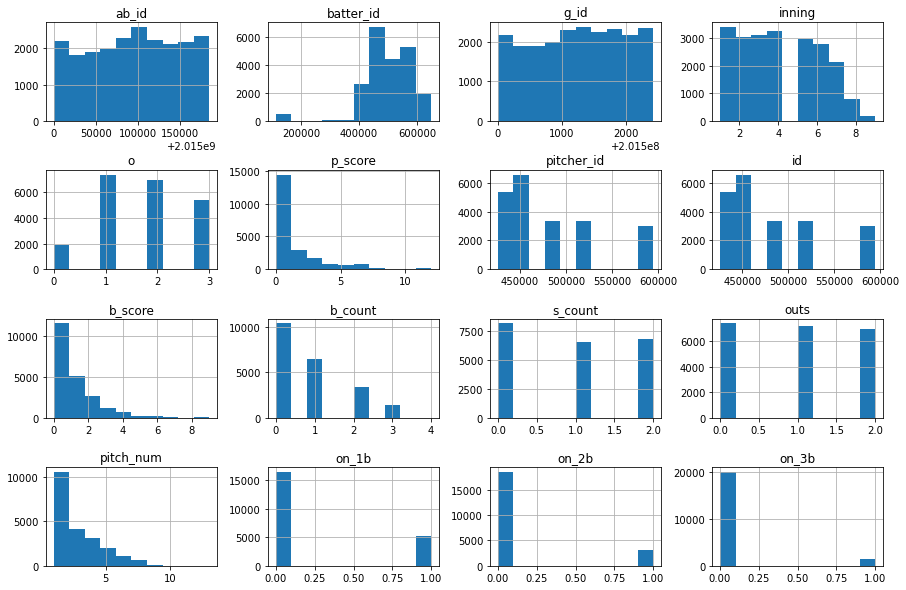

In [28]:
data.hist(figsize = (15,10))
plt.subplots_adjust(hspace = 0.5);

## Broad Strategies moving forward


We can try a couple different methods, one looking at correlating features for a given pitch type, and the other replacing the pitch type with integer values so we can include it in our correlation calculation. We can also try a chi-square test or multi-log regrerssion to compare categorical and continuous variables




Here is the distribution of all pitches thrown by the 7 pitchers in 2015

In [29]:
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
IN      13
EP       4
FA       2
PO       2
FS       1
Name: pitch_type, dtype: int64

Text(0.5, 1.0, 'Distribution of pitches  (7 starting pitchers in 2015)')

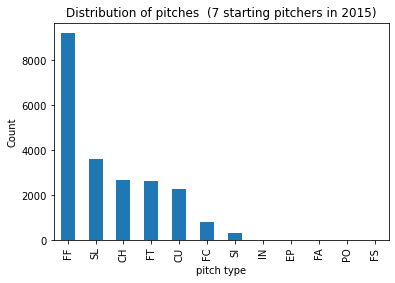

In [30]:
#pitch distribution independent of count
data.pitch_type.value_counts().plot(kind='bar')
plt.xlabel('pitch type')
plt.ylabel('Count')
plt.title('Distribution of pitches  (7 starting pitchers in 2015)')
#plt.plot()

To simplify the analysis, we can get rid of pitches thrown only a few times, such as the eephus

In [31]:
pitch_types = {'FF': 1, 'SL': 2, 'CU': 3, 'FT': 4, 'CH': 5, 'FC': 6, 'SI': 7}
data = data[data.pitch_type.isin(pitch_types.keys())]
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64


The plots below demonstrate how the distribution of pitch types vary depending on the count. 

# Change data15 name

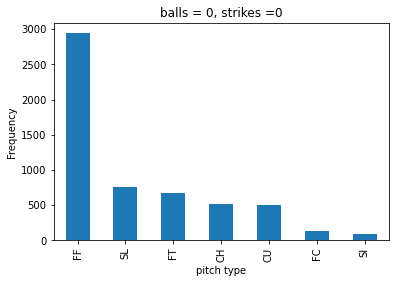

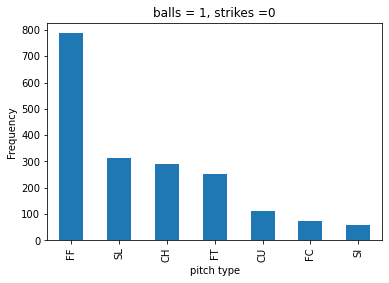

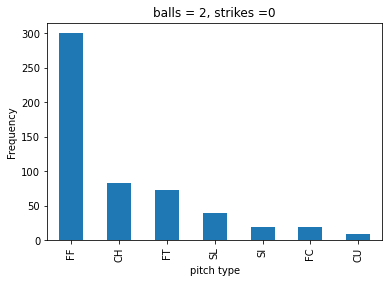

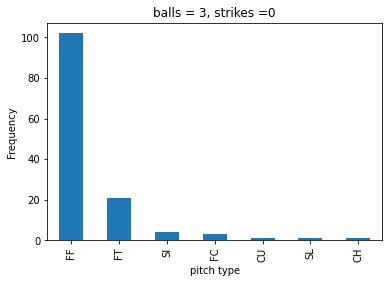

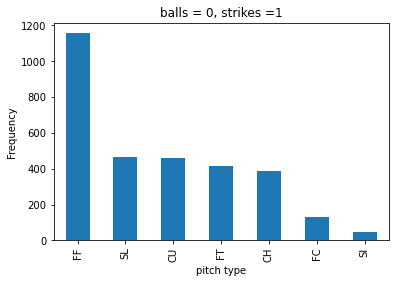

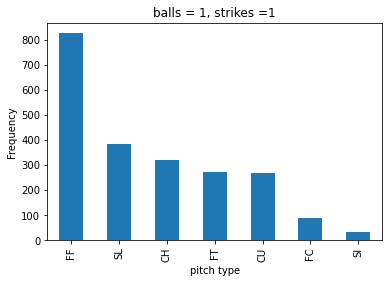

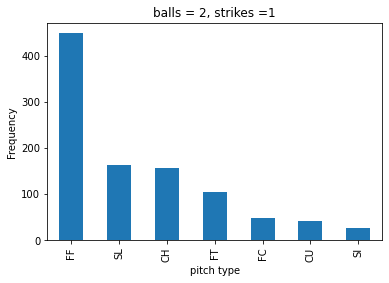

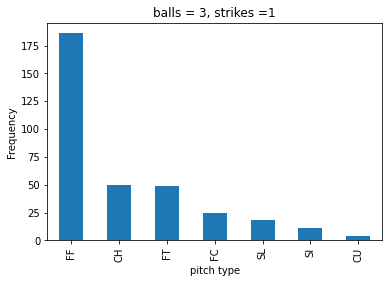

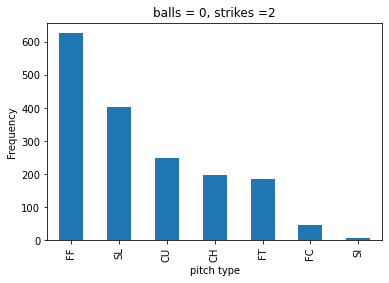

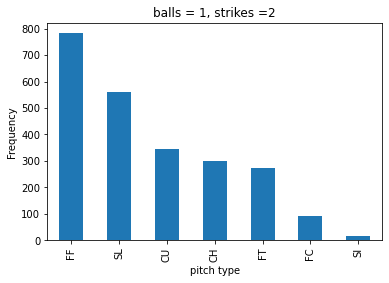

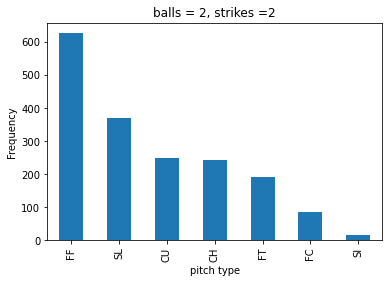

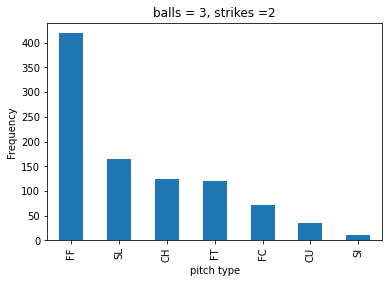

In [32]:
data15clean=data
#plots that show the distribution of pitches depending on the balls and strikes 
for i in range(3):
    for j in range(4):
        plt.figure()
        data15clean[np.logical_and(data15clean.loc[:, 's_count'].astype(int) == i ,\
                                   data15clean.loc[:, 'b_count'].astype(int) == j)]\
        .pitch_type.value_counts().plot(kind = 'bar')
        plt.xlabel('pitch type')
        plt.ylabel('Frequency')
        plt.title('balls = ' +str(j)+', strikes =' +str(i))
        plt.show()

If you are familiar with baseball, these distributions may not come as a surprise.

One can see that in counts favoring the pitcher (0 balls 2 strikes, 1 ball 2 strikes etc), it is more common to see pitchers throw a more diverse selection of pitches (sliders, curveballs etc). With counts favoring the hitter (2+ balls, 0 strikes etc), pitchers throw the fastball more often to avoid walking batters (throwing 4 balls which puts the hitter on first base) as it is easier to control.

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
Other immediate factors to consider that may influence the type of pitch being thrown include whether there are runners on base, and how many outs there are. 
</div>

For example, with the bases loaded (runners on first, second, and third), a pitcher may be less likely to throw breaking pitches which could end up outside of the strike zone, as a walk (4 balls) would result in a run being scored. Alternatively, if there are less than 2 outs and runners in scoring position (second or third base), a pitcher may be more inclined to throw breaking pitches to induce swings and misses. In this scenario, the negatives of allowing another runner on base (via a walk) could be outweighed by the positives of striking the batter out, as any hit would likely result in a run, and if a fast runner is on third, he will likely score on any kind of contact (even if it results in an out). I.e. a sacrifice fly or groundout which doesn't end the inning. 

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
We will now look at the distribution of pitches for each of the 8 runners-on-base scenarios. 
</div>

In [33]:
data[['on_1b','on_2b','on_3b']].head(20)

,on_1b,on_2b,on_3b
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


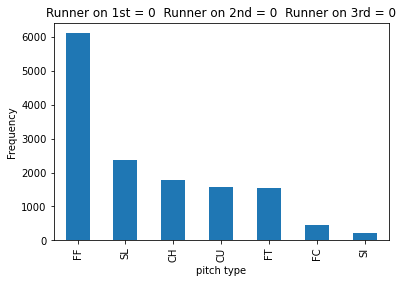

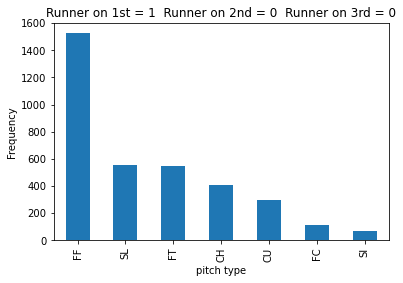

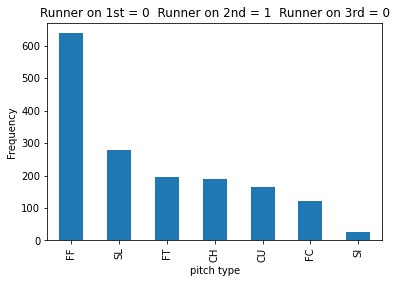

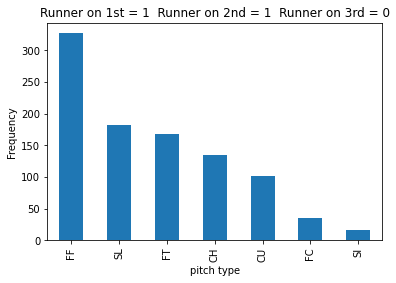

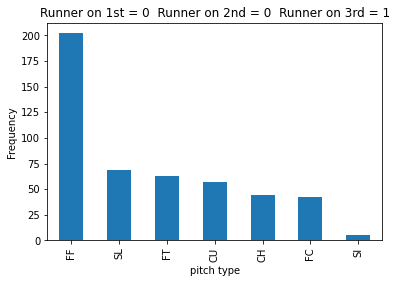

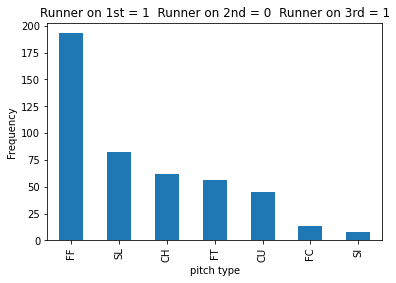

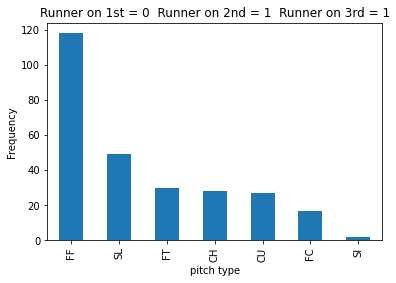

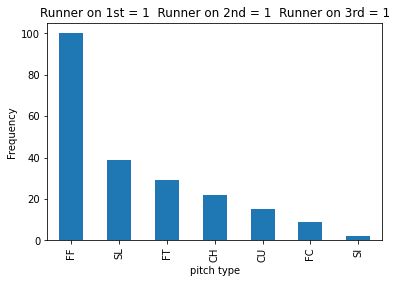

In [34]:
for k in range(2):
    for j in range(2):
        for i in range(2):
            plt.figure()
            data[np.logical_and(np.logical_and(data.loc[:, 'on_1b'].astype(int) == i ,\
                                       data.loc[:, 'on_2b'].astype(int) == j),\
                               data.loc[:, 'on_3b'].astype(int)==k)]\
            .pitch_type.value_counts().plot(kind = 'bar')
            plt.xlabel('pitch type')
            plt.ylabel('Frequency')
            plt.title('Runner on 1st = ' +str(i)+'  Runner on 2nd = ' +str(j)+'  Runner on 3rd = ' +str(k))
            plt.show()

In [35]:
#https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python/42818547

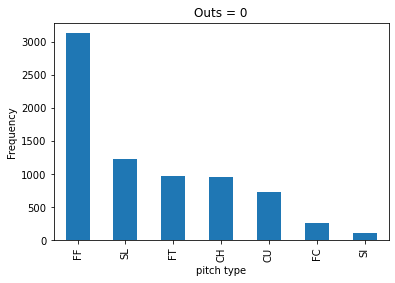

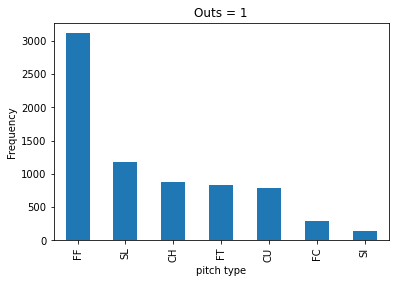

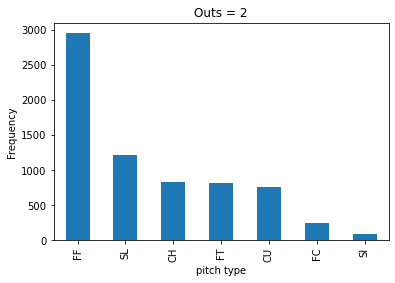

In [36]:
for i in range(3):
    plt.figure()
    data[data.loc[:, 'outs'].astype(int) == i].pitch_type.value_counts().plot(kind = 'bar')
    plt.xlabel('pitch type')
    plt.ylabel('Frequency')
    plt.title('Outs = ' +str(i))
    plt.show()

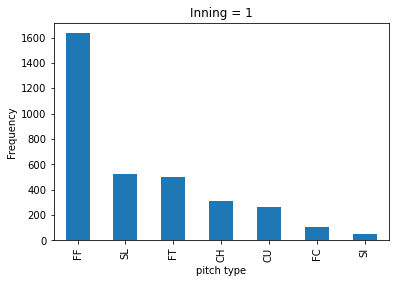

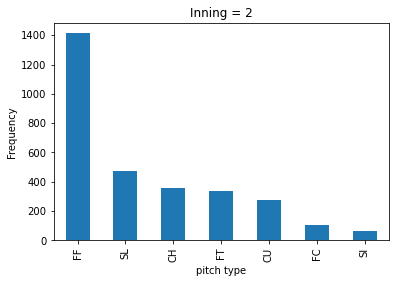

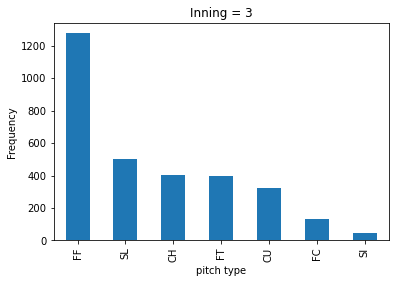

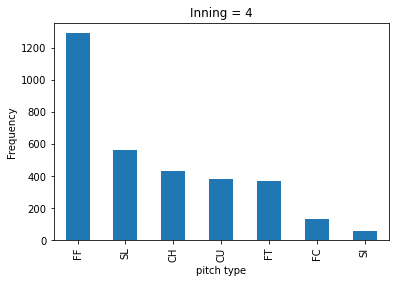

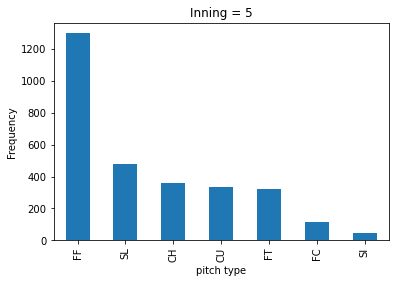

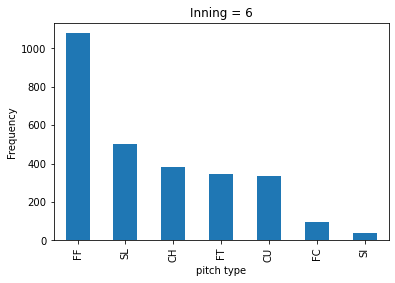

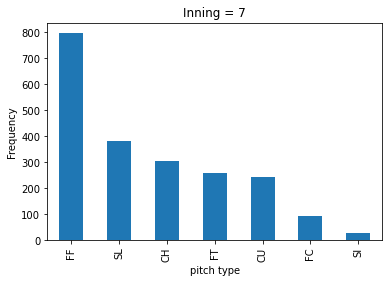

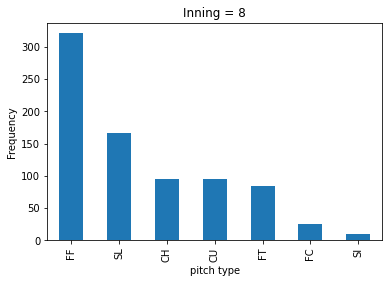

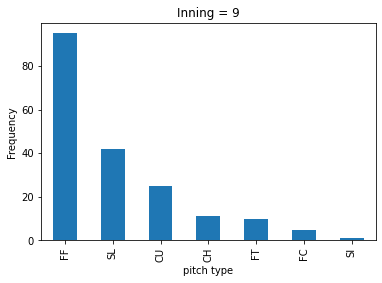

In [37]:
for i in range(1,10):
    plt.figure()
    data[data.loc[:, 'inning'].astype(int) == i].pitch_type.value_counts().plot(kind = 'bar')
    plt.xlabel('pitch type')
    plt.ylabel('Frequency')
    plt.title('Inning = ' +str(i))
    plt.show()

While the sample size becomes drastically smaller for the later innings, we can see some trends in that the pitches become more closely distributed. Conceptually, this makes sense because as a pitcher faces a lineup for the 3rd or even 4th time, they tend to diversify their repertoir depending on how the game has played out. 

Another (more even niche idea?) is that the way baseball is currently played and managed (with analytics driving many decisions), it is increasingly rare for a starting pitcher to pitch more than 7 innings. So, starters only pitch into the 8th and 9th innings if they are having a very dominant outing, perhaps even chasing a complete game shutout, no hitter, or perfect game. Having such an outing typically comes with the pitcher feeling confident with their entire arsenal of pitches.

### Pitch percentages by inning

In [39]:
percentages = pd.DataFrame()
for i in range(1,10):
    inning = []
    percentages[str(i)] = data[data.loc[:, 'inning'].astype(int) == i].pitch_type\
    .value_counts()/ data[data.loc[:, 'inning'].astype(int) == i].shape[0] *100

percentages

,1,2,3,4,5,6,7,8,9
FF,48.242245,46.633663,41.326861,39.901174,43.828204,38.763035,37.689394,40.225564,50.264550
SL,15.361891,15.643564,16.245955,17.418159,16.232668,18.122977,18.181818,20.927318,22.222222
FT,14.771049,11.221122,12.912621,11.488573,10.957051,12.441568,12.310606,10.526316,5.291005
CH,9.276219,11.815182,13.106796,13.403335,12.242137,13.736066,14.488636,11.904762,5.820106
CU,7.799114,9.141914,10.550162,11.890056,11.227596,12.010068,11.553030,11.904762,13.227513
FC,3.072378,3.498350,4.304207,4.138357,3.922895,3.451996,4.450758,3.258145,2.645503
SI,1.477105,2.046205,1.553398,1.760346,1.589449,1.474290,1.325758,1.253133,0.529101


In [41]:
transPerc = percentages.transpose(copy = True)
transPerc

,FF,SL,FT,CH,CU,FC,SI
1,48.242245,15.361891,14.771049,9.276219,7.799114,3.072378,1.477105
2,46.633663,15.643564,11.221122,11.815182,9.141914,3.498350,2.046205
3,41.326861,16.245955,12.912621,13.106796,10.550162,4.304207,1.553398
4,39.901174,17.418159,11.488573,13.403335,11.890056,4.138357,1.760346
5,43.828204,16.232668,10.957051,12.242137,11.227596,3.922895,1.589449
6,38.763035,18.122977,12.441568,13.736066,12.010068,3.451996,1.474290
7,37.689394,18.181818,12.310606,14.488636,11.553030,4.450758,1.325758
8,40.225564,20.927318,10.526316,11.904762,11.904762,3.258145,1.253133
9,50.264550,22.222222,5.291005,5.820106,13.227513,2.645503,0.529101


<AxesSubplot:>

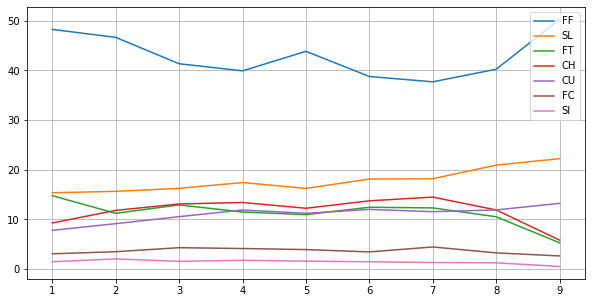

In [44]:
transPerc.plot(figsize=(10,5), grid=True)

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: purple; color: white; margin-bottom: 20px'> 
Lets look at each pitchers tendancy vs left and right handed batters
        
</div>

In [46]:
#stand = L, R (batter stance)

# P_throws is for pitcher
data.p_throws.value_counts()

R    11696
L     9884
Name: p_throws, dtype: int64

L L


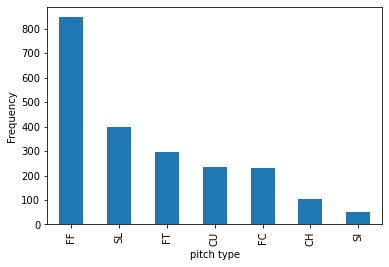

L R


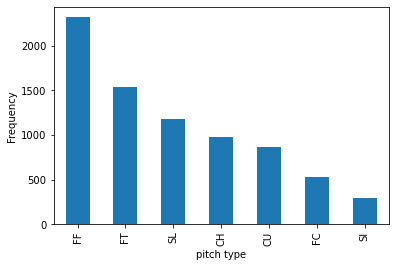

R L


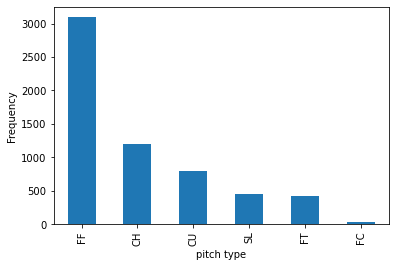

R R


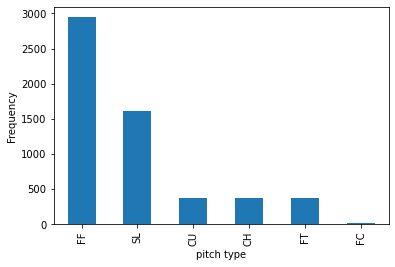

In [60]:
hand = ['L','R']
for h in hand:
    for b in hand:
        plt.figure()
        data[np.logical_and(data.loc[:, 'p_throws'] ==  h,\
                                       data.loc[:, 'stand'] == b)].pitch_type.value_counts().plot(kind = 'bar')
        plt.xlabel('pitch type')
        plt.ylabel('Frequency')
        
        print(h,b)
        plt.show()

# This is interesting

In [ ]:
fig, ax = plt.subplots()


### Some notes to keep in mind for revisions after 
After doing some initial EDA, a few extra changes seem to be in order (that could be considered part of the data wrangling process). 

We are going to add a column that gives the count in format (balls, strikes) as one variable. This will be added in addition to the b_count and s_count features already present. 


### I'm making duplicates of the data at this point because I'm not quite sure what I may want to come back to / restore

In [14]:
data_counts = data
data_counts['b_s'] = list(zip(data.b_count.astype(int), data.s_count.astype(int)))
data_counts

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,b_s
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(0, 0)"
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,"(0, 1)"
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,"(0, 2)"
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,"(0, 2)"
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,"(1, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21597,2015184080,150029,Strikeout,201502429,4,2,0,R,594798,R,...,FF,0.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,"(1, 2)"
21598,2015184080,150029,Strikeout,201502429,4,2,0,R,594798,R,...,CH,0.0,2.0,2.0,1.0,5.0,0.0,0.0,0.0,"(2, 2)"
21599,2015184081,519208,Groundout,201502429,4,3,0,R,594798,L,...,CH,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,"(0, 0)"
21600,2015184081,519208,Groundout,201502429,4,3,0,R,594798,L,...,CH,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,"(0, 1)"


### To simplify the analysis, we can get rid of pitches thrown only a few times, such as the eephus

In [15]:
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
IN      13
EP       4
PO       2
FA       2
FS       1
Name: pitch_type, dtype: int64

In [25]:
pitch_types = {'FF': 1, 'SL': 2, 'CU': 3, 'FT': 4, 'CH': 5, 'FC': 6, 'SI': 7}
data = data[data.pitch_type.isin(pitch_types.keys())]
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: purple; color: white; margin-bottom: 20px'> 
Instead of using the following dictionary mapping, we will likely encode the target variable (pitch_type) using pd.get_dummies.
        
</div>
This isn't something we need to decide now, as we will probably become more informed on the best way to format the target feature in the feature engineering and preprocessing stages. 

So, for now, we can keep this pitch types dict as it may be useful in the future


<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
I will go ahead and make new variables X and y, where y will represent the encoded pitch_types, and X the remaining columns

    
</div>
Encoding the variable now will allow us to view it in a correlation matrix


In [26]:
df_encoded = pd.get_dummies(data, columns = ['pitch_type'])

In [27]:
X = data

In [28]:
X = data.drop(columns = ["pitch_type"])
y = pd.get_dummies(data.pitch_type)

In [29]:
X.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,b_s
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(0, 0)"
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,"(0, 1)"
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,"(0, 2)"
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,"(0, 2)"
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,"(1, 2)"


In [30]:
y.head()

,CH,CU,FC,FF,FT,SI,SL
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0


In [31]:
df_encoded.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,...,on_1b,on_2b,on_3b,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,pitch_type_FT,pitch_type_SI,pitch_type_SL
ab_id,1.000000,0.066903,0.999990,0.031160,0.025252,-0.038286,-0.079386,-0.030436,-0.079386,-0.010309,...,-0.023544,0.005777,-0.001844,-0.028320,0.028064,-0.013189,0.010426,-0.020969,-0.022307,0.020585
batter_id,0.066903,1.000000,0.066976,0.015350,-0.015345,0.029796,-0.032086,0.014186,-0.032086,-0.010759,...,-0.017788,-0.009712,-0.001003,-0.003693,0.018759,0.001808,0.004614,-0.008635,-0.016909,-0.005969
g_id,0.999990,0.066976,1.000000,0.030997,0.025185,-0.038856,-0.079378,-0.030707,-0.079378,-0.010753,...,-0.023490,0.005678,-0.001826,-0.028286,0.028066,-0.013256,0.010348,-0.020838,-0.022317,0.020580
inning,0.031160,0.015350,0.030997,1.000000,-0.024354,0.463933,-0.038163,-0.026499,-0.038163,0.248316,...,-0.016526,0.004429,-0.005498,0.030314,0.042675,0.008500,-0.056326,-0.024044,-0.010338,0.032868
o,0.025252,-0.015345,0.025185,-0.024354,1.000000,-0.002336,-0.017009,0.008482,-0.017009,0.029612,...,0.131952,0.124471,0.077562,-0.010893,0.019553,-0.003671,0.002955,-0.027432,-0.003412,0.016613
p_score,-0.038286,0.029796,-0.038856,0.463933,-0.002336,1.000000,-0.021980,-0.119982,-0.021980,0.127250,...,-0.021132,0.023750,0.020565,0.021812,0.008019,-0.005019,-0.020867,-0.008077,-0.018058,0.017464
pitcher_id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,...,0.008286,-0.002459,-0.012370,0.049914,-0.057852,-0.102059,-0.135799,0.270983,-0.065709,0.019967
top,-0.030436,0.014186,-0.030707,-0.026499,0.008482,-0.119982,-0.020313,1.000000,-0.020313,-0.029223,...,0.000981,-0.013916,0.005212,-0.005194,0.001391,0.037876,0.004494,-0.008658,0.019709,-0.020812
id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,...,0.008286,-0.002459,-0.012370,0.049914,-0.057852,-0.102059,-0.135799,0.270983,-0.065709,0.019967
b_score,-0.010309,-0.010759,-0.010753,0.248316,0.029612,0.127250,0.007893,-0.029223,0.007893,1.000000,...,0.050906,0.079692,0.074264,0.042938,0.010509,0.031160,-0.069321,0.019268,0.026311,0.003685


Keep in mind that the bottom right corner of the correlation matrix/heatmap shouldn't be a point of focus, as the pitches are mutually exclusive and will naturally be negatively correlated with each other

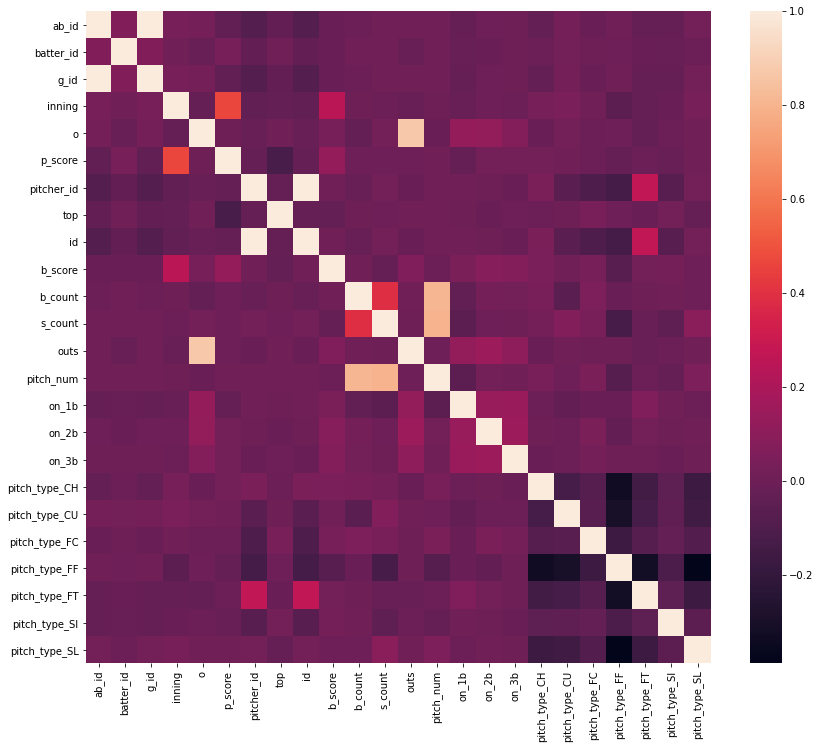

In [32]:
plt.subplots(figsize=(14,12))
sns.heatmap(df_encoded.corr());

# END?
 # rest might be more appropriate to do in feature selection /preprocessing

### Alternative approach

We will not do this now, but another way to look at this problem would be to add a column which just categorizes the pitch to whether it is a fastball (fourseam, twoseam, cutter) or a breaking ball (slider, curveball, changeup, sinker). 

In the Astros cheating scandal, they would only signal to the hitter whether or not the pitch was a fastball (as this would be the most important factor in a hitters timing)


Here is code that could be used for that

    pitch_types_fast_small = {'FF': 1, 'SL': 0, 'CU': 0, 'FT': 1, 'CH': 0, 'FC': 1, 'SI': 0}
    data['fast_or_slow'] = data_counts.pitch_type.replace(pitch_types_fast_small)

In [167]:
data_counts.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,...,s_count,outs,pitch_num,on_1b,on_2b,on_3b,p_type_number,fast_or_slow,bathand_num,pitchhand_num
ab_id,1.000000,0.066903,0.999990,0.031160,0.025252,-0.038286,-0.079386,-0.030436,-0.079386,-0.010309,...,0.016936,0.016970,0.013513,-0.023544,0.005777,-0.001844,-0.036807,-0.008572,-0.030355,0.055225
batter_id,0.066903,1.000000,0.066976,0.015350,-0.015345,0.029796,-0.032086,0.014186,-0.032086,-0.010759,...,0.010564,-0.015953,0.011239,-0.017788,-0.009712,-0.001003,-0.008886,-0.000408,-0.028866,0.014729
g_id,0.999990,0.066976,1.000000,0.030997,0.025185,-0.038856,-0.079378,-0.030707,-0.079378,-0.010753,...,0.016944,0.016870,0.013510,-0.023490,0.005678,-0.001826,-0.036747,-0.008589,-0.030493,0.055273
inning,0.031160,0.015350,0.030997,1.000000,-0.024354,0.463933,-0.038163,-0.026499,-0.038163,0.248316,...,-0.003159,-0.015308,0.000143,-0.016526,0.004429,-0.005498,0.032625,-0.069254,0.020039,-0.012215
o,0.025252,-0.015345,0.025185,-0.024354,1.000000,-0.002336,-0.017009,0.008482,-0.017009,0.029612,...,0.022871,0.871059,-0.011948,0.131952,0.124471,0.077562,-0.017209,-0.016689,0.041955,0.021394
p_score,-0.038286,0.029796,-0.038856,0.463933,-0.002336,1.000000,-0.021980,-0.119982,-0.021980,0.127250,...,0.006253,0.005559,0.008254,-0.021132,0.023750,0.020565,0.008220,-0.028264,0.032601,-0.005800
pitcher_id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,...,0.022360,-0.011781,0.013915,0.008286,-0.002459,-0.012370,0.092947,0.004301,0.014413,-0.048429
top,-0.030436,0.014186,-0.030707,-0.026499,0.008482,-0.119982,-0.020313,1.000000,-0.020313,-0.029223,...,0.007208,0.010206,0.009383,0.000981,-0.013916,0.005212,0.016922,0.013408,0.010979,-0.032372
id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,...,0.022360,-0.011781,0.013915,0.008286,-0.002459,-0.012370,0.092947,0.004301,0.014413,-0.048429
b_score,-0.010309,-0.010759,-0.010753,0.248316,0.029612,0.127250,0.007893,-0.029223,0.007893,1.000000,...,-0.024268,0.058167,-0.008354,0.050906,0.079692,0.074264,0.078505,-0.044745,0.035230,-0.096366


In [168]:
data_counts.dtypes

ab_id              int64
batter_id          int64
event             object
g_id               int64
inning             int64
o                  int64
p_score            int64
p_throws          object
pitcher_id         int64
stand             object
top                 bool
id                 int64
last_name         object
date              object
type              object
pitch_type        object
b_score          float64
b_count          float64
s_count          float64
outs             float64
pitch_num        float64
on_1b            float64
on_2b            float64
on_3b            float64
b_s               object
p_type_number      int64
fast_or_slow       int64
bathand_num        int64
pitchhand_num      int64
dtype: object

# Question for Mentor Call. 

Are there alternatives to converting categorical data into numerical data for the purpose of including them in correlation calculations (and other modeling methods which seem to require data as int64 or float64 type). 

In [169]:
#adding numerical column for batter and pitcher handedness
leftright = {'L' : 0, 'R' :1}
data_counts['bathand_num'] = data_counts.stand.replace(leftright)
data_counts['pitchhand_num'] = data_counts.p_throws.replace(leftright)

### Here we filter the data on whether or not it is numerical, creating a new df with only numerical data. 

In [170]:
coltypes = []
for col in data_counts.columns:
    if data_counts[col].dtype == 'int64' or data_counts[col].dtype == 'float64':
        coltypes.append(col)   

In [171]:
#check to make sure we want these columns
coltypes

['ab_id',
 'batter_id',
 'g_id',
 'inning',
 'o',
 'p_score',
 'pitcher_id',
 'id',
 'b_score',
 'b_count',
 's_count',
 'outs',
 'pitch_num',
 'on_1b',
 'on_2b',
 'on_3b',
 'p_type_number',
 'fast_or_slow',
 'bathand_num',
 'pitchhand_num']

In [172]:
data_num = data_counts[coltypes]

    path2 = '../data/interim'
    save_file(data_num, 'numerical_data_eda.csv', path2)

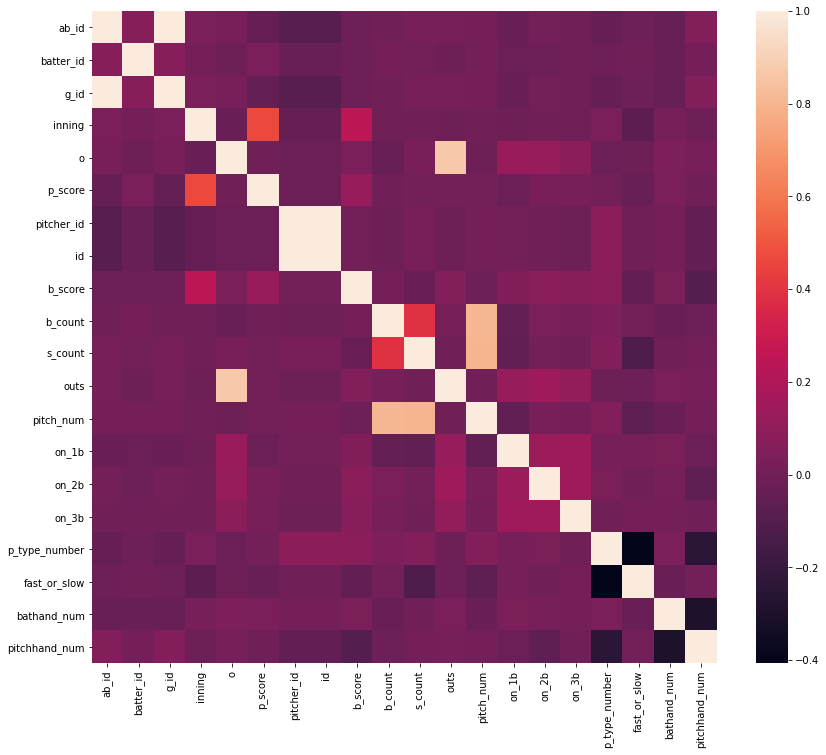

In [173]:
plt.subplots(figsize=(14,12))
sns.heatmap(data_num.corr());

In [174]:
data_num[data_num['fast_or_slow']==100].shape

(0, 20)

In [175]:
data_num[data_num['fast_or_slow']!=100].shape

(21580, 20)

In [176]:
ratio = 12650/21580
ratio

0.5861909175162188

# Baseline score
simply guessing based on overall frequency would suggest that a pitch thrown in 2015 had a 58.6% chance of being a fastball. 



### More feature filtering
Before proceding further, lets remove some features that are not directly related to the actual pitch. 

These include pitcher_id, batter_id, g_id, and ab_id

In [177]:
dtest = data_num.drop(columns =['pitcher_id' , 'batter_id' , 'g_id', 'ab_id'])

### Scale the numerical data

In [178]:
scale_num_data = scale(dtest)

In [179]:
scale_num_data

array([[-1.41363168, -0.79187237, -0.73229365, ...,  0.84019572,
        -1.28356064, -1.08780816],
       [-1.41363168, -0.79187237, -0.73229365, ...,  0.84019572,
        -1.28356064, -1.08780816],
       [-1.41363168, -0.79187237, -0.73229365, ...,  0.84019572,
        -1.28356064, -1.08780816],
       ...,
       [ 0.00686772,  1.35655681, -0.73229365, ..., -1.19019887,
        -1.28356064,  0.91927974],
       [ 0.00686772,  1.35655681, -0.73229365, ..., -1.19019887,
        -1.28356064,  0.91927974],
       [ 0.00686772,  1.35655681, -0.73229365, ...,  0.84019572,
        -1.28356064,  0.91927974]])

In [180]:
#create a df with the scaled data
scaled_df = pd.DataFrame(scale_num_data, columns = dtest.columns)

In [181]:
scaled_df

,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,p_type_number,fast_or_slow,bathand_num,pitchhand_num
0,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,-1.127674,-1.200552,-1.094505,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
1,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,0.075550,-1.200552,-0.513075,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
2,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,1.278774,-1.200552,0.068354,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
3,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,-0.866515,1.278774,-1.200552,0.649784,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,-1.283561,-1.087808
4,-1.413632,-0.791872,-0.732294,-0.516273,-0.698988,0.211011,1.278774,-1.200552,1.231214,-0.560367,-0.407023,-0.266198,0.280949,-1.190199,-1.283561,-1.087808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,0.006868,0.282342,-0.732294,2.115632,-0.698988,0.211011,1.278774,0.026265,0.649784,-0.560367,-0.407023,-0.266198,-0.901821,0.840196,0.779083,0.919280
21576,0.006868,0.282342,-0.732294,2.115632,-0.698988,1.288537,1.278774,0.026265,1.231214,-0.560367,-0.407023,-0.266198,1.463720,-1.190199,0.779083,0.919280
21577,0.006868,1.356557,-0.732294,2.115632,-0.698988,-0.866515,-1.127674,1.253082,-1.094505,-0.560367,-0.407023,-0.266198,1.463720,-1.190199,-1.283561,0.919280
21578,0.006868,1.356557,-0.732294,2.115632,-0.698988,-0.866515,0.075550,1.253082,-0.513075,-0.560367,-0.407023,-0.266198,1.463720,-1.190199,-1.283561,0.919280


In [182]:
scaled_df.mean()

inning          -1.535239e-15
o                2.282285e-15
p_score         -2.982971e-15
id              -3.618154e-16
b_score         -2.550117e-16
b_count          4.852493e-16
s_count         -2.578970e-15
outs            -1.525337e-15
pitch_num       -4.437400e-15
on_1b           -2.411828e-16
on_2b            2.332554e-15
on_3b           -3.223336e-15
p_type_number   -5.533248e-15
fast_or_slow     8.199548e-16
bathand_num      1.004839e-15
pitchhand_num    4.164839e-15
dtype: float64

In [183]:
scaled_df.std()

inning           1.000023
o                1.000023
p_score          1.000023
id               1.000023
b_score          1.000023
b_count          1.000023
s_count          1.000023
outs             1.000023
pitch_num        1.000023
on_1b            1.000023
on_2b            1.000023
on_3b            1.000023
p_type_number    1.000023
fast_or_slow     1.000023
bathand_num      1.000023
pitchhand_num    1.000023
dtype: float64

# Could use input here for PCA

In [184]:
pitch_PCA = PCA().fit(scale_num_data)

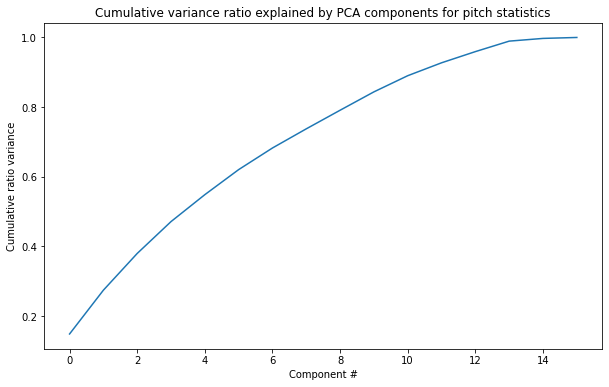

In [185]:
plt.subplots(figsize=(10, 6))
plt.plot(pitch_PCA.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for pitch statistics');

# Preliminary logistic regression
https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html

In [186]:
dep = dtest[['fast_or_slow']]
indy = dtest.drop(columns = ['fast_or_slow'])

In [187]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(indy, dep, test_size = 0.25, random_state = 123)

add stratify parameter, makes sure the dist of training and test look similar

In [188]:
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(16185, 15) (5395, 15) (16185, 1) (5395, 1)


In [189]:
Ytrain = np.ravel(Ytrain)
Ytest = np.ravel(Ytest)

In [190]:
logR = LogisticRegression()

In [191]:
logR.fit(Xtrain, Ytrain)

LogisticRegression()

In [192]:
logR.score(Xtrain, Ytrain)

0.5866543095458758

## logR score is 0.5866 without any adjustments (it is essentially dumb)

In [193]:
y_pred = logR.predict(Xtest)

In [194]:
logR.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [195]:
print(y_pred)

[1 1 1 ... 1 1 1]


In [196]:
np.mean(y_pred)

1.0

In [197]:
#https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

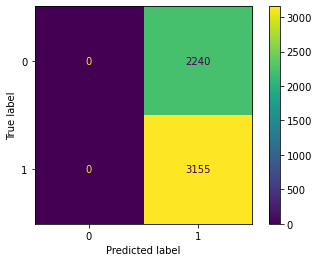

In [198]:
cm = confusion_matrix(Ytest, y_pred)
#ConfusionMatrixDisplay(confusion_matrix(Ytest, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=logR.classes_)
disp.plot()
plt.show()

In [199]:
from sklearn.dummy import DummyRegressor

dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(Xtrain, Ytrain)
dumb_reg.constant_

array([[0.58665431]])

In [162]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [66]:
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

In [73]:
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

In [74]:
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [75]:
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [200]:
X_train, X_test, y_train, y_test = train_test_split(dtest.drop(columns='p_type_number'), 
                                                    dtest.p_type_number, test_size=0.3, 
                                                    random_state=47)

In [67]:
#https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
parameters = dict(solver=solver_list)
lr = LogisticRegression(random_state=47, multi_class="auto", n_jobs=-1, C=1)
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']

for score, solver, in zip(scores, solver_list):
    print(f"{solver}: {score:.3f}")

C:\Users\alber\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\alber\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\alber\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
C:\Users\alber\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1355: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn("'n_jobs' > 1 does not have any effect wh

liblinear: 0.595
newton-cg: 0.604
lbfgs: 0.553
sag: 0.424
saga: 0.424


### newton-cg appears to be best solver

In [68]:
clf.cv_results_

{'mean_fit_time': array([0.15819974, 3.77944927, 1.01439385, 1.06548767, 0.81574287]),
 'std_fit_time': array([0.00365358, 0.12834253, 0.00835551, 0.05275879, 0.17696422]),
 'mean_score_time': array([0.0019237 , 0.00200195, 0.00200276, 0.0019927 , 0.00197449]),
 'std_score_time': array([9.56045857e-04, 1.91017180e-05, 3.66079287e-06, 2.12858527e-05,
        3.22821221e-05]),
 'param_solver': masked_array(data=['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'solver': 'liblinear'},
  {'solver': 'newton-cg'},
  {'solver': 'lbfgs'},
  {'solver': 'sag'},
  {'solver': 'saga'}],
 'split0_test_score': array([0.59497022, 0.59728657, 0.55129054, 0.42422237, 0.42422237]),
 'split1_test_score': array([0.59516716, 0.59251903, 0.55445217, 0.42436279, 0.42436279]),
 'split2_test_score': array([0.59516716, 0.60642171, 0.54882489, 0.42436279, 0.42436279]),
 'split3_test_score': a

## Interesting improvement in the score here to 0.645

In [201]:
lr = LogisticRegression(random_state=47, multi_class="auto", solver = 'newton-cg', n_jobs=-1, C=1)

lr.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=47, solver='newton-cg')

In [202]:
#https://scikit-learn.org/stable/modules/generated/sklearn.
#linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV.score
lr.score(X_train,y_train)

0.6451741030054283

In [203]:
results2 = lr.predict(X_test)

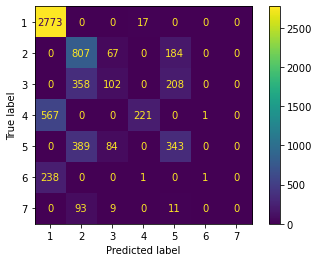

In [204]:
cm = confusion_matrix(y_test, results2)
#ConfusionMatrixDisplay(confusion_matrix(Ytest, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=lr.classes_)
disp.plot()
plt.show()

There are some interesting trends here. The mistakes do show a relationship between 1,4,6 and 2,3,5

Interesting what happenes below as well...

In [212]:
from sklearn.linear_model import LogisticRegressionCV
lrCV = LogisticRegressionCV(cv=5, random_state = 47, solver = 'newton-cg').fit(X_train, y_train)

C:\Users\alber\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alber\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
C:\Users\alber\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\alber\anaconda3\lib\s

In [213]:
resultsLRCV = lrCV.predict(X_test)

In [214]:
lrCV.score(X_train,y_train)

0.6985303852773732

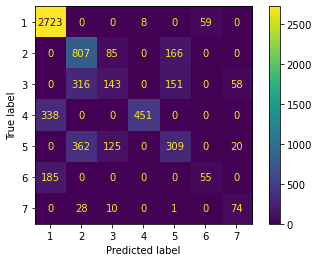

In [215]:
cm3 = confusion_matrix(y_test, resultsLRCV)
#ConfusionMatrixDisplay(confusion_matrix(Ytest, y_pred))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm3,
                             display_labels=lrCV.classes_)
disp2.plot()
plt.show()

### Score improves to .699

# Ignore code below

In [100]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)

In [101]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [102]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.41240635, 0.40966205, 0.41446922, 0.42184685, 0.42899859])

In [103]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.41747661166714434, 0.007038100549250458)

In [104]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        'simpleimputer__strategy': ['mean', 'median']
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None],
 'simpleimputer__strategy': ['mean', 'median']}

In [105]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [106]:
%%time
#Code task 25#
#Now call the `GridSearchCV`'s `fit()` method with `X_train` and `y_train` as arguments
#to actually start the grid search. This may take a minute or two.
rf_grid_cv.fit(X_train, y_train)

Wall time: 2min 25s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'simpleimputer__strategy': [

In [107]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

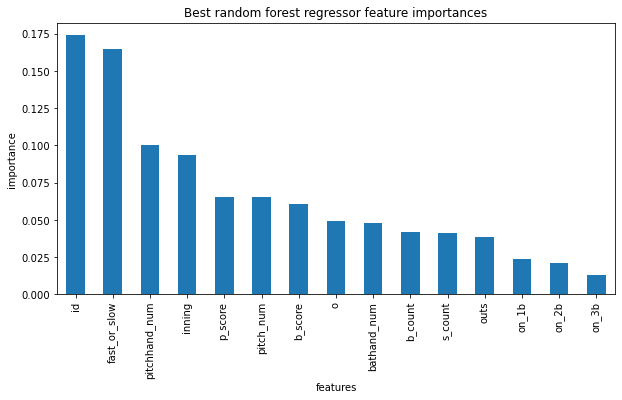

In [108]:
plt.subplots(figsize=(10, 5))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [86]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=15),
    LinearRegression()
)

In [87]:
pipe15.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x00000218972A7B80>)),
                ('linearregression', LinearRegression())])

In [88]:
y_tr_pred = pipe15.predict(X_train)
y_te_pred = pipe15.predict(X_test)

In [89]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.23630801664263346, 0.2438995718381628)

In [90]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(1.227208168888531, 1.2370606297804343)

In [91]:
pipe15.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [92]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [93]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
#grid_params

In [94]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(k=15,
                                                    score_func=<function f_regression at 0x00000218972A7B80>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15]})

In [95]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [96]:
lr_grid_cv.best_params_

{'selectkbest__k': 11}

In [98]:
lr_grid_cv.cv_results_

{'mean_fit_time': array([0.0727994 , 0.08060064, 0.08059983, 0.07519894, 0.0533999 ,
        0.02859869, 0.02540026, 0.02380009, 0.02499995, 0.02539935,
        0.02930627, 0.02831364, 0.03039865, 0.03020005, 0.02380004]),
 'std_fit_time': array([3.70912198e-03, 1.45955814e-02, 4.71536217e-03, 1.14953842e-02,
        1.34847497e-02, 1.74374611e-03, 1.01979564e-03, 3.99929365e-04,
        1.54218308e-06, 4.90739217e-04, 3.70929681e-03, 1.46719395e-03,
        1.02084298e-03, 1.16584525e-03, 2.85538630e-03]),
 'mean_score_time': array([0.00600023, 0.00760055, 0.00720077, 0.00640078, 0.00400028,
        0.00259986, 0.00199976, 0.00239983, 0.00219908, 0.00260019,
        0.00359988, 0.00318899, 0.00280008, 0.0026001 , 0.00200024]),
 'std_score_time': array([6.32786668e-04, 1.02001994e-03, 1.32689905e-03, 7.99560931e-04,
        6.32108772e-04, 4.89512573e-04, 7.32531142e-07, 4.91129833e-04,
        4.00473089e-04, 4.89882177e-04, 7.99834843e-04, 3.80563990e-04,
        4.00233336e-04, 4.89

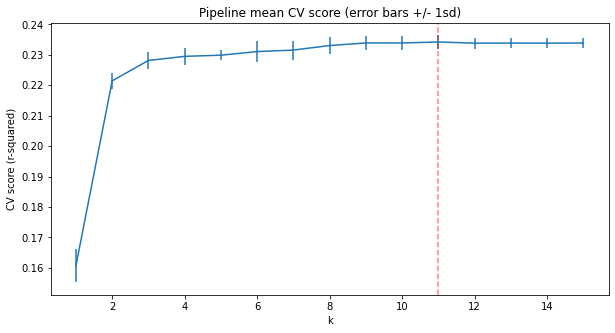

In [99]:
#Code task 20#
#Assign the value of k from the above dict of `best_params_` and assign it to `best_k`
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [ ]:
#https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
parameters = dict(solver=solver_list)
lr = LogisticRegression(random_state=47, multi_class="auto", n_jobs=-1, C=1)
clf = GridSearchCV(lr, parameters, cv=5)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']

for score, solver, in zip(scores, solver_list):
    print(f"{solver}: {score:.3f}")

# A different approach

In [28]:
fast1 = fast.drop(columns = ['pitcher_id' , 'batter_id' , 'g_id', 'top'])
breaking1 = breaking.drop(columns = ['pitcher_id' , 'batter_id' , 'g_id', 'top'])
fast1

In [23]:
type(fast1.corr())

pandas.core.frame.DataFrame

In [24]:
fast1.corr()

,ab_id,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.024543,0.022000,-0.045467,-0.099389,-0.006660,0.006196,0.009554,0.010507,0.013227,-0.034396,0.012028,0.008138
inning,0.024543,1.000000,0.000465,0.482200,-0.024076,0.277544,0.026253,0.027639,0.009812,0.031501,-0.003016,0.024040,0.016114
o,0.022000,0.000465,1.000000,-0.003249,-0.021434,0.030030,-0.052868,0.030931,0.868600,-0.021286,0.139422,0.113967,0.086016
p_score,-0.045467,0.482200,-0.003249,1.000000,-0.017235,0.146717,0.013954,0.009163,0.010872,0.018686,-0.017342,0.033175,0.042732
id,-0.099389,-0.024076,-0.021434,-0.017235,1.000000,-0.008211,-0.009507,0.065047,-0.019844,0.039396,0.020346,0.003535,-0.010730
b_score,-0.006660,0.277544,0.030030,0.146717,-0.008211,1.000000,0.026162,-0.008709,0.058388,0.007690,0.069726,0.083909,0.075699
b_count,0.006196,0.026253,-0.052868,0.013954,-0.009507,0.026162,1.000000,0.394606,0.005449,0.816015,-0.038845,0.032586,0.024468
s_count,0.009554,0.027639,0.030931,0.009163,0.065047,-0.008709,0.394606,1.000000,0.014182,0.798104,-0.047320,0.021236,0.023596
outs,0.010507,0.009812,0.868600,0.010872,-0.019844,0.058388,0.005449,0.014182,1.000000,0.005745,0.131576,0.142565,0.122714
pitch_num,0.013227,0.031501,-0.021286,0.018686,0.039396,0.007690,0.816015,0.798104,0.005745,1.000000,-0.053564,0.032521,0.029364


In [30]:
breaking1.corr()

,ab_id,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.040016,0.028768,-0.030061,-0.055574,-0.016791,-0.019030,0.027012,0.023258,0.013699,-0.009299,-0.005002,-0.013568
inning,0.040016,1.000000,-0.057824,0.439900,-0.051940,0.206999,-0.031848,-0.062329,-0.048374,-0.052153,-0.029806,-0.023830,-0.031612
o,0.028768,-0.057824,1.000000,-0.001444,-0.008735,0.027899,0.002744,0.009450,0.873568,-0.002795,0.122856,0.136272,0.066044
p_score,-0.030061,0.439900,-0.001444,1.000000,-0.026245,0.102497,-0.008853,-0.003709,-0.001384,-0.008247,-0.023939,0.010923,-0.007372
id,-0.055574,-0.051940,-0.008735,-0.026245,1.000000,0.035654,-0.021364,-0.022089,0.002261,-0.012016,-0.012215,-0.003889,-0.016195
b_score,-0.016791,0.206999,0.027899,0.102497,0.035654,1.000000,0.002493,-0.060259,0.059197,-0.036780,0.031202,0.076014,0.073340
b_count,-0.019030,-0.031848,0.002744,-0.008853,-0.021364,0.002493,1.000000,0.385616,0.032862,0.797267,-0.040302,0.025343,0.015081
s_count,0.027012,-0.062329,0.009450,-0.003709,-0.022089,-0.060259,0.385616,1.000000,-0.023069,0.795805,-0.050602,-0.020155,-0.024383
outs,0.023258,-0.048374,0.873568,-0.001384,0.002261,0.059197,0.032862,-0.023069,1.000000,-0.001941,0.112643,0.159684,0.095063
pitch_num,0.013699,-0.052153,-0.002795,-0.008247,-0.012016,-0.036780,0.797267,0.795805,-0.001941,1.000000,-0.050438,0.005701,-0.003990


# lets look for differences in corr by subtracting the two


In [51]:
subtract = fast1.corr().subtract(breaking1.corr())
subtract

,ab_id,inning,o,p_score,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,0.000000,-0.015474,-0.006767,-0.015406,-0.043815,0.010131,0.025226,-0.017459,-0.012750,-0.000472,-0.025098,0.017030,0.021706
inning,-0.015474,0.000000,0.058289,0.042300,0.027863,0.070545,0.058101,0.089969,0.058186,0.083653,0.026790,0.047870,0.047725
o,-0.006767,0.058289,0.000000,-0.001805,-0.012699,0.002131,-0.055612,0.021481,-0.004967,-0.018491,0.016566,-0.022306,0.019972
p_score,-0.015406,0.042300,-0.001805,0.000000,0.009010,0.044219,0.022807,0.012871,0.012256,0.026933,0.006597,0.022252,0.050103
id,-0.043815,0.027863,-0.012699,0.009010,0.000000,-0.043866,0.011857,0.087135,-0.022105,0.051412,0.032561,0.007424,0.005464
b_score,0.010131,0.070545,0.002131,0.044219,-0.043866,0.000000,0.023669,0.051550,-0.000810,0.044470,0.038524,0.007895,0.002358
b_count,0.025226,0.058101,-0.055612,0.022807,0.011857,0.023669,0.000000,0.008989,-0.027413,0.018748,0.001457,0.007244,0.009387
s_count,-0.017459,0.089969,0.021481,0.012871,0.087135,0.051550,0.008989,0.000000,0.037250,0.002299,0.003282,0.041391,0.047979
outs,-0.012750,0.058186,-0.004967,0.012256,-0.022105,-0.000810,-0.027413,0.037250,0.000000,0.007686,0.018933,-0.017119,0.027651
pitch_num,-0.000472,0.083653,-0.018491,0.026933,0.051412,0.044470,0.018748,0.002299,0.007686,0.000000,-0.003126,0.026821,0.033354


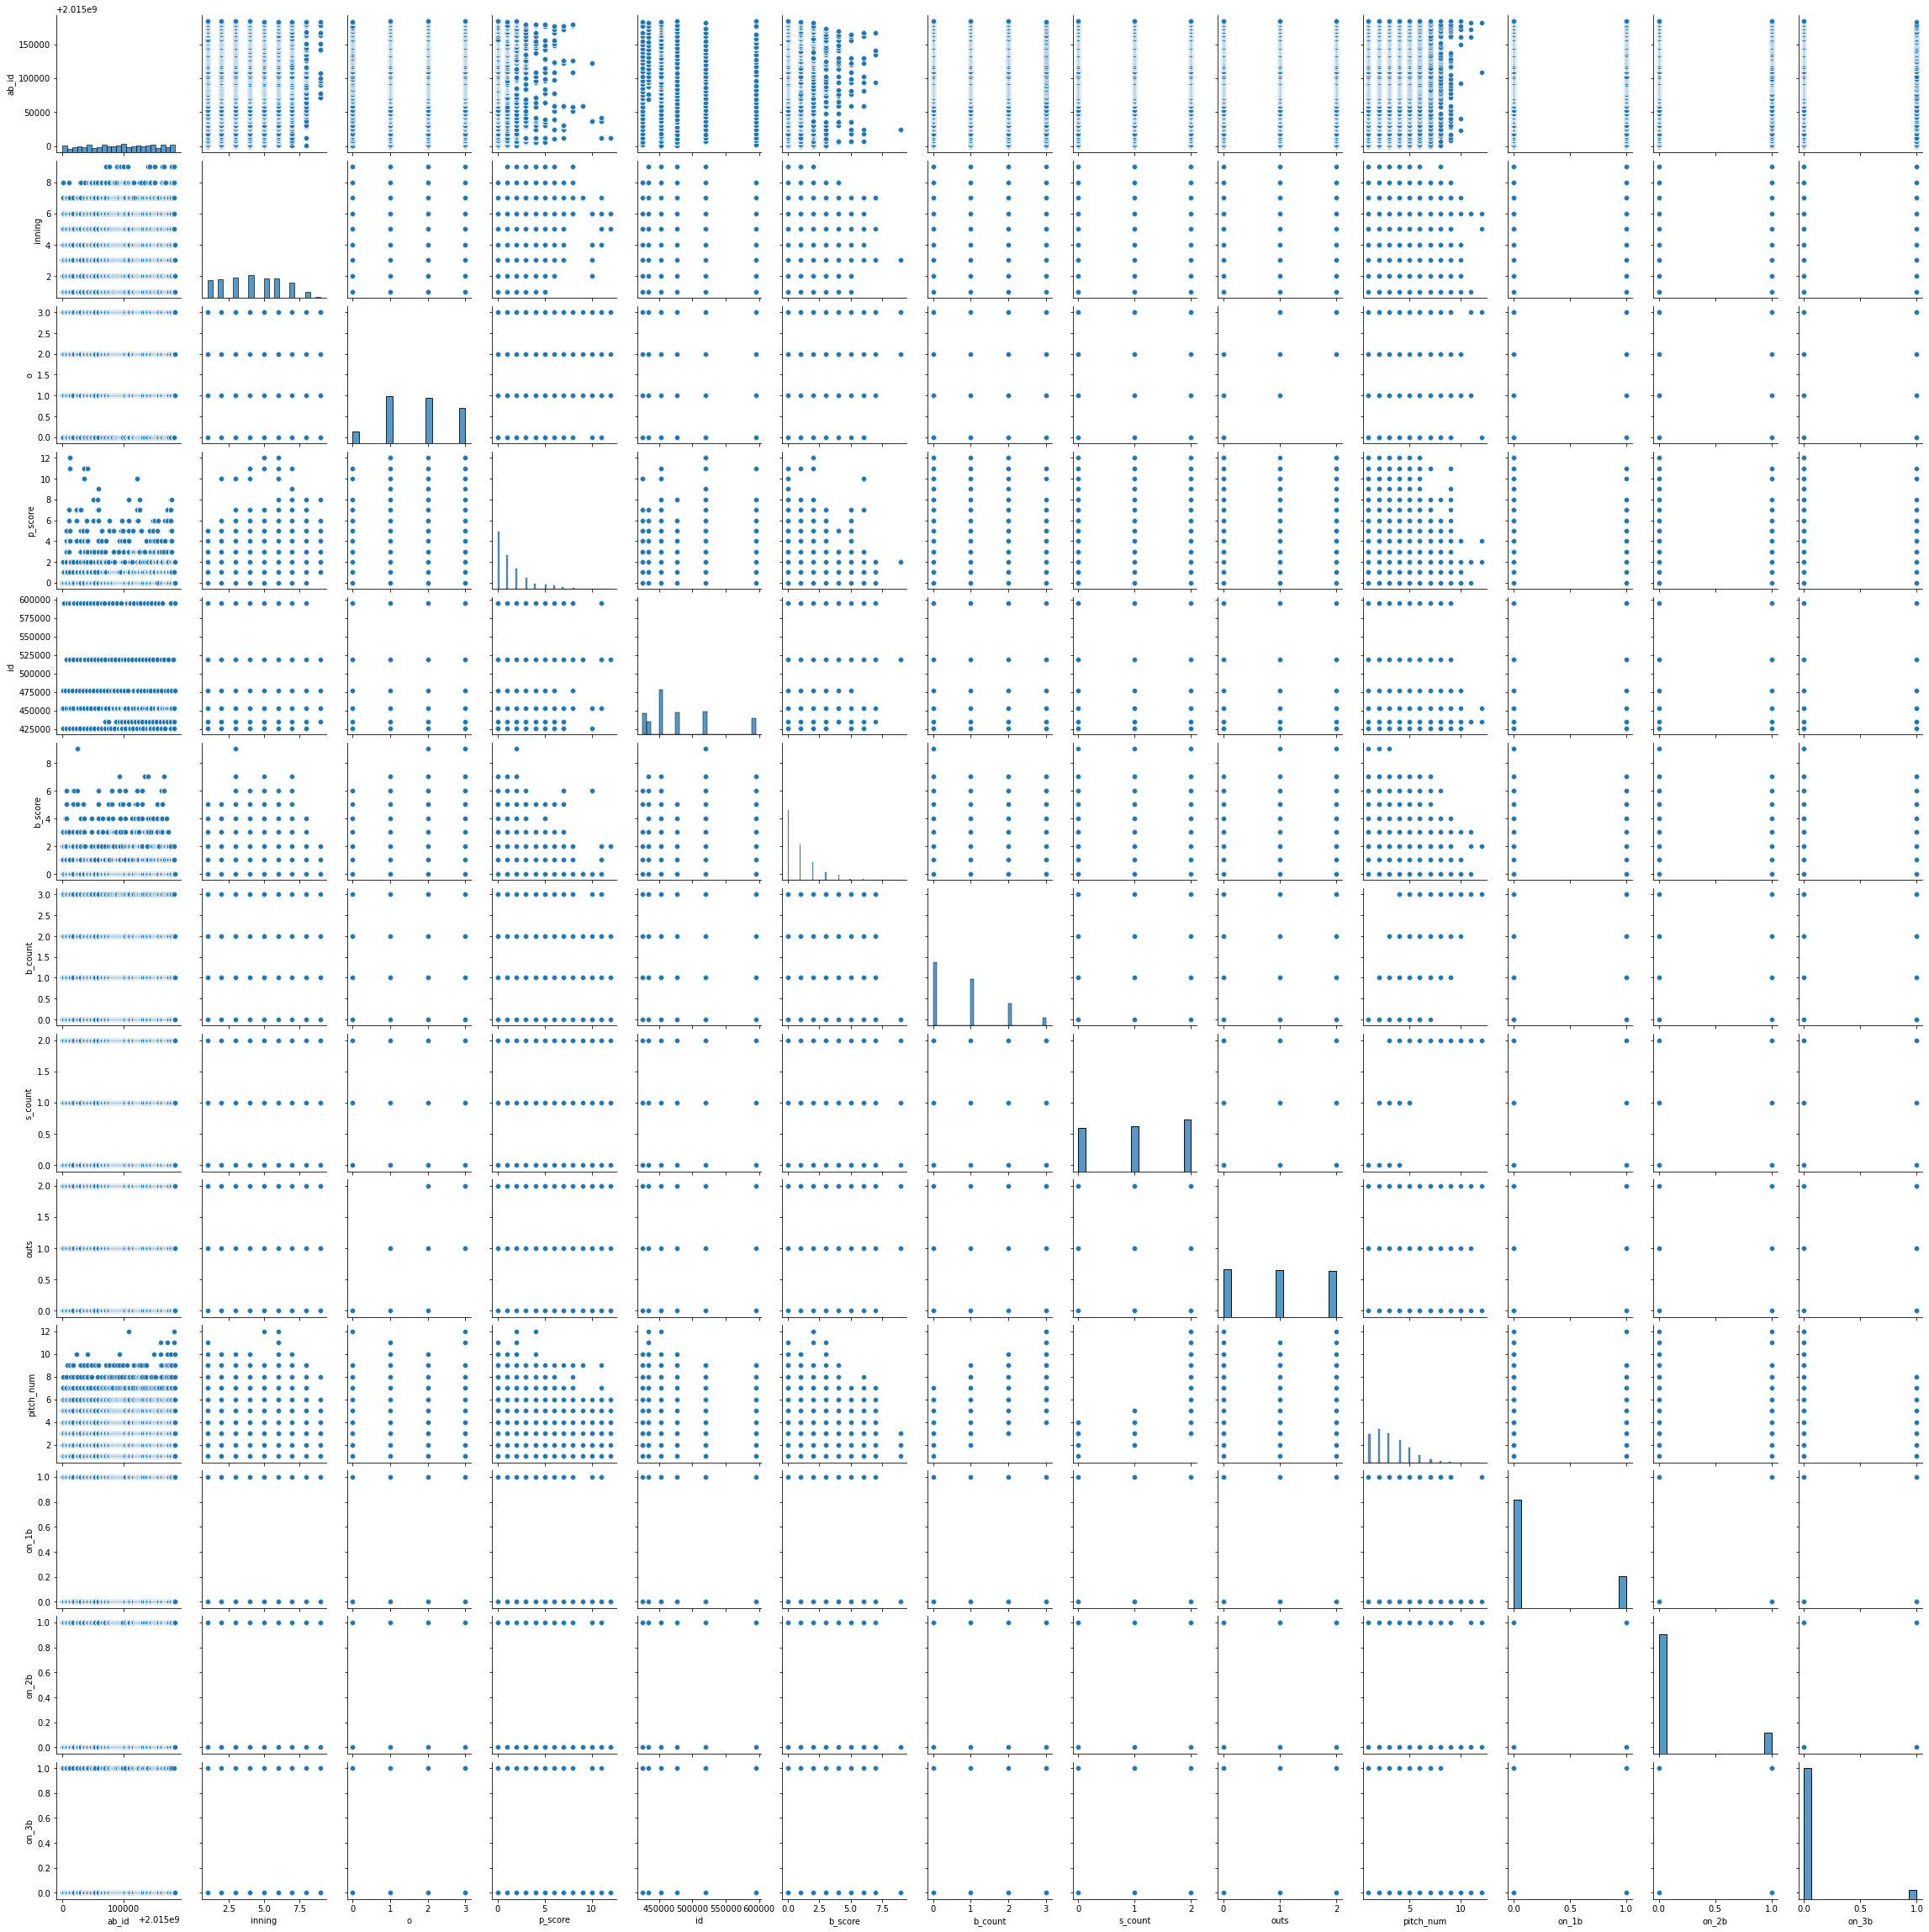

In [31]:
sns.pairplot(breaking1)

In [43]:
ffast = pd.DataFrame(data[data.pitch_type.isin(['FF', 'FT'])])
temp = [1 for x in range(len(ffast))]
ffast['pitch'] = temp

bbreaking =pd.DataFrame(data[~data.pitch_type.isin(['FF', 'FT'])])
temp2 = [0 for x in range(len(bbreaking))]
bbreaking['pitch'] = temp2

In [44]:
ffast.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11836 entries, 0 to 21601
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       11836 non-null  int64  
 1   batter_id   11836 non-null  int64  
 2   event       11836 non-null  object 
 3   g_id        11836 non-null  int64  
 4   inning      11836 non-null  int64  
 5   o           11836 non-null  int64  
 6   p_score     11836 non-null  int64  
 7   p_throws    11836 non-null  object 
 8   pitcher_id  11836 non-null  int64  
 9   stand       11836 non-null  object 
 10  top         11836 non-null  bool   
 11  id          11836 non-null  int64  
 12  last_name   11836 non-null  object 
 13  date        11836 non-null  object 
 14  type        11836 non-null  object 
 15  pitch_type  11836 non-null  object 
 16  b_score     11836 non-null  float64
 17  b_count     11836 non-null  float64
 18  s_count     11836 non-null  float64
 19  outs        11836 non-nul

In [47]:
data2 = pd.concat([ffast, bbreaking])
data2.describe()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,pitch
count,2.160200e+04,21602.000000,2.160200e+04,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000,21602.000000
mean,2.015095e+09,494408.535784,2.015013e+08,3.985187,1.737247,1.427970,480563.939867,480563.939867,0.889408,0.804648,0.936673,0.979122,2.882279,0.238959,0.142579,0.066244,0.547912
std,5.243495e+04,84185.384730,6.922723e+02,2.111705,0.930645,1.950648,54038.089424,54038.089424,1.271358,0.928528,0.831183,0.815218,1.719559,0.426458,0.349651,0.248714,0.497711
min,2.015000e+09,112526.000000,2.015000e+08,1.000000,0.000000,0.000000,425844.000000,425844.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.015051e+09,452239.000000,2.015007e+08,2.000000,1.000000,0.000000,452657.000000,452657.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.015097e+09,500208.000000,2.015013e+08,4.000000,2.000000,1.000000,453286.000000,453286.000000,0.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,1.000000
75%,2.015140e+09,546318.000000,2.015019e+08,6.000000,2.000000,2.000000,519242.000000,519242.000000,1.000000,1.000000,2.000000,2.000000,4.000000,0.000000,0.000000,0.000000,1.000000
max,2.015184e+09,648717.000000,2.015024e+08,9.000000,3.000000,12.000000,594798.000000,594798.000000,9.000000,4.000000,2.000000,2.000000,13.000000,1.000000,1.000000,1.000000,1.000000


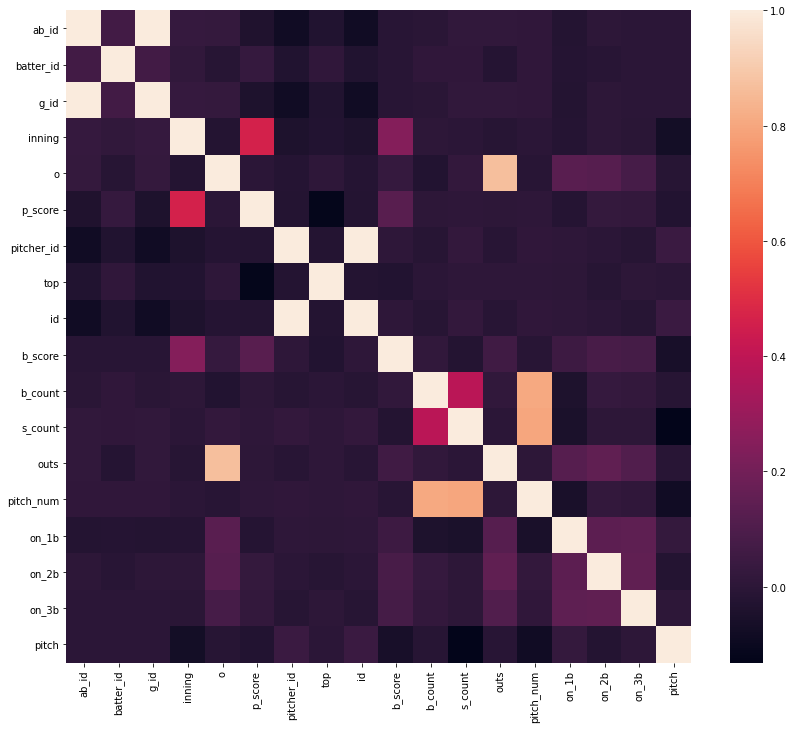

In [46]:
plt.subplots(figsize=(14,12))
sns.heatmap(data2.corr());

In [25]:
fast = data[data.pitch_type.isin(['FF', 'FT'])]

breaking = data[~data.pitch_type.isin(['FF', 'FT'])]

In [26]:
fast.pitch_type.value_counts()

FF    9201
FT    2635
Name: pitch_type, dtype: int64

In [27]:
breaking.pitch_type.value_counts()

SL    3637
CH    2667
CU    2282
FC     814
SI     344
IN      13
EP       4
PO       2
FA       2
FS       1
Name: pitch_type, dtype: int64

## Can covert this into a function to subset data on counts

In [41]:
data15clean=data

In [ ]:
def count_subset(df):
    for i in range(3):
        for j in range(4):
            df[np.logical_and(df.loc[:, 's_count'].astype(int) == i) , \
              df.loc[:, 'b_count'].astype(int) == j]
            

### Note: This is nowhere near being completed.

I'm submitting what I have for now so you have access to it for our call tomorrow. Nothing really jumped out as being an obvious important feature so this notebook is sort of a combination of further data wrangling/refining and then trying out really rough preprocessing/modelling to gain a better idea of what EDA to focus on. 

I had a couple of questions about how to deal with categorical features of interest (i.e. pitch type), as well as how to evaluate PCA or look for other kinds of dimensionality reduction. Also, advice on what other kinds of visual devices to use in EDA. 

If theres time, there were some scores from slopily done logistic regression models that were pretty surprising/interesting. 